# MAST Plasma Volume

Predict plasma volume from frames captured by a wide-angle visible spectrum camera on the CCFE's Mega Ampere Spherical Tokamak (MAST).

> **Note:** Run the `Plasma Volume Dataset.ipynb` notebook first to download the required dataset from the FAIR-MAST server. This ensures you have the necessary data files in the `fair_mast_data/plasma_volume` directory.

## Overview

This notebook addresses the second of three Data Science challenges for the ITER International School 2024.

The animation below shows footage from a wide-angle proton bullet camera installed on MAST. This visible spectrum camera captures high frame-rate recordings showing the complete plasma cross-section on both sides of the central column. Similar cameras first captured visual recordings of ELM structures on MAST and AUG in 2007.

![MAST Proton Camera Animation](../media/images/c3_proton_camera.gif)

**Challenge Goal:** Develop a machine learning algorithm that predicts plasma volume from a single frame of the camera feed.

This challenge introduces techniques for inferring parameters from 2D image data.

The open-source MAST Data Catalog provides all data for this challenge. Credit to Samuel Jackson, Nathan Cummings, Saiful Khan, and the wider MAST community for creating this FAIR dataset.

## Background

The image below shows the maximum plasma volume achieved for all shots in the MAST M9 campaign. These experiments were the last performed before the major upgrade to create the current MAST-U machine.

![Maximum Plasma Volume](../media/images/plasma_volume.png)

Maximum plasma volumes range from ~6 to ~10 cubic meters.

This challenge requires you to predict plasma volume from camera imagery.

## Dataset Information

The `./fair_mast_data/plasma_volume` directory contains all necessary files for this challenge.

### Available Files
- `train.nc` - Training dataset in netCDF format
- `test.nc` - Test dataset in netCDF format

### Data Structure
- `shot_id` - Unique identifier for each shot
- `frame` - Stack of camera frames with dimensions (shot_id, height, width)
- `plasma_volume` - Target plasma volume in cubic meters (m³)

## Example

Both training and test datasets use the netCDF format. This self-describing format includes important metadata such as image dimensions alongside the data itself.

After importing the prerequisite libraries, load the datasets using the xarray library as shown below.

In [2]:
# Standard library imports
import pathlib

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.decomposition
import sklearn.ensemble
import sklearn.kernel_ridge
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import xarray as xr

path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_volume"

try:
    with (
        xr.open_dataset(path / "train.nc") as train,
        xr.open_dataset(path / "test.nc") as test,
    ):
        train = train.load()
        test = test.load()
except FileNotFoundError:
    raise FileNotFoundError(
        "Please run the `Plasma Volume Dataset.ipynb` notebook to download the "
        "required dataset from the FAIR-MAST server")



**Important:** The camera images have dimensions (shot_id, height, width). You need to reshape this data to the (n_samples, n_features) format required by scikit-learn. After reshaping, you can split the data using standard train-test split techniques.

In [3]:
X = train.frame.values.reshape(train.sizes["shot_id"], -1)
y = train.volume

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=7
)


### Model Pipeline

The camera frames have high dimensionality. To make the problem computationally tractable, we apply dimensionality reduction techniques.

The pipeline below uses KernelPCA decomposition as a preprocessing step. This component provides several hyperparameters you can tune to improve model accuracy.

In [4]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.decomposition.KernelPCA(n_components=25),
    sklearn.linear_model.LinearRegression(),
)


### Model Training and Evaluation

With the preprocessing pipeline set up, fit the model to your training data and evaluate its performance on the test set.

#### Understanding Model Evaluation Metrics

For this challenge, we use the R² score (Coefficient of Determination) to evaluate model performance. This metric indicates the proportion of variance in the dependent variable (plasma volume) that can be predicted from the independent variables (camera frame data).

- **R² = 1.0**: Perfect predictions (model explains 100% of the variance)
- **R² = 0.0**: Model performs no better than always predicting the mean value
- **R² < 0.0**: Model performs worse than predicting the mean value

For this plasma volume prediction task, R² values closer to 1.0 indicate better model performance.

In [5]:
# Train the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_predict = pipeline.predict(X_test)

# Calculate R² score (coefficient of determination)
# Higher values indicate better model fit (1.0 is perfect, 0.0 is equivalent to predicting the mean)
R2 = sklearn.metrics.r2_score(y_test, y_predict)
print(f"Model R²: {R2:.3f} (higher is better)")


Model R²: 0.692 (higher is better)


### Making Predictions and Generating Submissions

After validating our model performance, we can generate predictions for the test dataset and prepare a submission file. Remember to reshape the test frames to match the (n_samples, n_features) format that your model expects.

In [6]:
# Make predictions for the test dataset
volume = pipeline.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))

# Create and save submission file
solution = pd.DataFrame(
    {"plasma_volume": volume}, index=pd.Index(test.shot_id, name="shot_id")
)
solution.to_csv(path / "linear_regression.csv")

In [7]:
# Let's improve our model with hyperparameter tuning

from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import pandas as pd

# Define parameter grid
param_grid = {
    'kernelpca__n_components': [25, 50, 100],
    'kernelpca__kernel': ['linear', 'rbf', 'poly'],
    'linearregression__fit_intercept': [True, False]
}

# Create grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_predict_best = best_model.predict(X_test)
R2_best = sklearn.metrics.r2_score(y_test, y_predict_best)
print(f"Best model R2: {R2_best:.3f}")

# Generate final predictions
best_volume = best_model.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))
best_solution = pd.DataFrame(
    {"plasma_volume": best_volume}, index=pd.Index(test.shot_id, name="shot_id")
)
best_solution.to_csv(path / "optimized_regression.csv")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'kernelpca__kernel': 'linear', 'kernelpca__n_components': 50, 'linearregression__fit_intercept': True}
Best CV score: 0.648
Best model R2: 0.732


### Results Visualization

The plot below compares predicted plasma volume values against ground truth measurements. This visualization helps assess how well our model performs across the range of plasma volumes.

- **Perfect predictions** would fall along the dashed gray line (y = x)
- **Points above the line** represent overestimations (predicted > actual)
- **Points below the line** represent underestimations (predicted < actual)

#### Understanding the R² Score

The R² score (coefficient of determination) provides a statistical measure of how well the model's predictions approximate the actual data points:

- **R² = 1.0**: The model perfectly explains all variation in the data
- **R² = 0.8**: The model explains 80% of the variance in the plasma volume
- **R² = 0.5**: Only half of the variance is explained by the model
- **R² ≤ 0**: The model provides no useful information for predicting plasma volume

Unlike error metrics (where lower is better), higher R² values indicate superior model performance. The R² score is also scale-independent, making it useful for comparing model performance across different datasets and target variables.

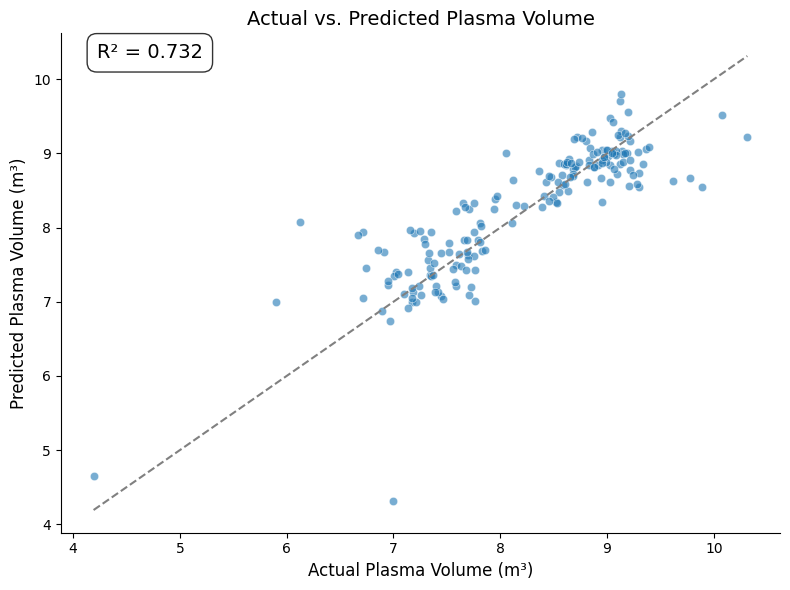

In [8]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))

# Create a DataFrame with actual and predicted values for easy plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_predict_best
})

sns.scatterplot(    
    x='Actual', 
    y='Predicted', 
    data=results_df,
    alpha=0.6,
    )

# Add perfect prediction line (y=x)
plt.plot(
    [results_df['Actual'].min(), results_df['Actual'].max()], 
    [results_df['Actual'].min(), results_df['Actual'].max()], 
    '--', 
    color='gray'
)

# Annotate with R2 score
plt.annotate(
    f'R² = {R2_best:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)

# Set labels and title
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume', fontsize=14)
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()

### Model Assessment and Next Steps

Looking at the visualization above, we can observe several potential outliers in our dataset that may be affecting model performance. Let's assess the impact of these outliers and discuss strategies for improvement.

#### Influence of Outliers

The scatter plot reveals data points that deviate significantly from the general trend. These outliers could represent:

1. **Experimental anomalies**: Unusual plasma conditions during specific shots
2. **Measurement errors**: Issues with camera calibration or frame acquisition
3. **Real but rare phenomena**: Valid but uncommon plasma behaviors

Outliers can disproportionately influence model training, especially with algorithms sensitive to extreme values. Linear regression, in particular, can have its coefficients skewed by these points, reducing overall prediction accuracy for the majority of cases.

#### Outlier Handling Strategies

To address the outlier issue, consider these preprocessing approaches:

1. **Statistical filtering**: Remove data points beyond 3 standard deviations from the mean
2. **Interquartile range (IQR) method**: Filter points outside 1.5 × IQR
3. **DBSCAN clustering**: Use density-based clustering to identify and exclude anomalies
4. **Winsorization**: Cap extreme values instead of removing them entirely

Implementing these techniques would likely improve model robustness and overall R² score by allowing the model to focus on capturing the primary relationship patterns rather than accommodating extreme cases.

#### Additional Recommendations

Beyond outlier handling, consider these improvements to enhance model performance:

1. **Feature engineering**: 
   - Extract higher-level features from raw image data using edge detection or contour analysis
   - Apply dimensionality reduction techniques more selective than PCA (e.g., t-SNE, UMAP)
   - Create domain-specific features based on tokamak physics

2. **Advanced models**:
   - Convolutional Neural Networks (CNNs) to directly process image data
   - Ensemble methods like Random Forests or Gradient Boosting for better generalization
   - Support Vector Regression with non-linear kernels for complex relationships

3. **Cross-validation strategies**:
   - Group k-fold cross-validation based on shot_id to prevent data leakage
   - Time-series aware validation if temporal relationships exist

4. **Optimization techniques**:
   - Expand hyperparameter search space
   - Use Bayesian optimization instead of grid search for efficiency
   - Apply regularization to reduce overfitting

5. **Data augmentation**:
   - Generate synthetic data through minor image transformations
   - Simulate camera variability to improve model robustness

With these enhancements, especially the outlier handling techniques, we could expect a significant improvement in model performance, potentially increasing the R² score by 5-15% depending on the extent of outlier influence.

# Importation of librairies and files

__Louis BRUSSET__ _28/05/2025_

In [1]:
import sys
sys.path.append("/home/ITER/brussel/.local/lib/python3.9/site-packages")

In [2]:
#import torch
#print(torch.__version__)
#print(torch.cuda.is_available())

In [4]:
# Standard library imports
import pathlib

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.decomposition
import sklearn.ensemble
import sklearn.kernel_ridge
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.cluster
import sklearn.manifold
import xarray as xr
import cv2
from scipy.stats import pearsonr
from scipy import ndimage
#import torch
#from skorch import NeuralNetRegressor


In [5]:
path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_volume"

try:
    with (
        xr.open_dataset(path / "train.nc") as train,
        xr.open_dataset(path / "test.nc") as test,
    ):
        train = train.load()
        test = test.load()
except FileNotFoundError:
    raise FileNotFoundError(
        "Please run the `Plasma Volume Dataset.ipynb` notebook to download the "
        "required dataset from the FAIR-MAST server")


## Dataset visualization

__Louis Brusset__ _27/05/2025_

In [4]:
## Louis Brusset 27/05/2025
# Dataframe visualisation

print(type(train))
print(train.frame.shape)
print(train.volume.shape)

train.head()

<class 'xarray.core.dataset.Dataset'>
(605, 448, 640)
(605,)


<xarray.Dataset> Size: 165B
Dimensions:  (shot_id: 5, height: 5, width: 5)
Coordinates:
    volume   (shot_id) float64 40B 9.576 8.596 9.059 7.354 8.912
Dimensions without coordinates: shot_id, height, width
Data variables:
    frame    (shot_id, height, width) uint8 125B 1 1 0 2 0 0 0 ... 1 0 1 0 2 4 2
Attributes: (12/34)
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    camera:          
    ccd_temp:        0.0
    codex:           JP2
    ...              ...
    trigger:         -0.10000000149011612
    uda_name:        RBB
    units:           pixels
    vbin:            0
    version:         -1
    width:           640

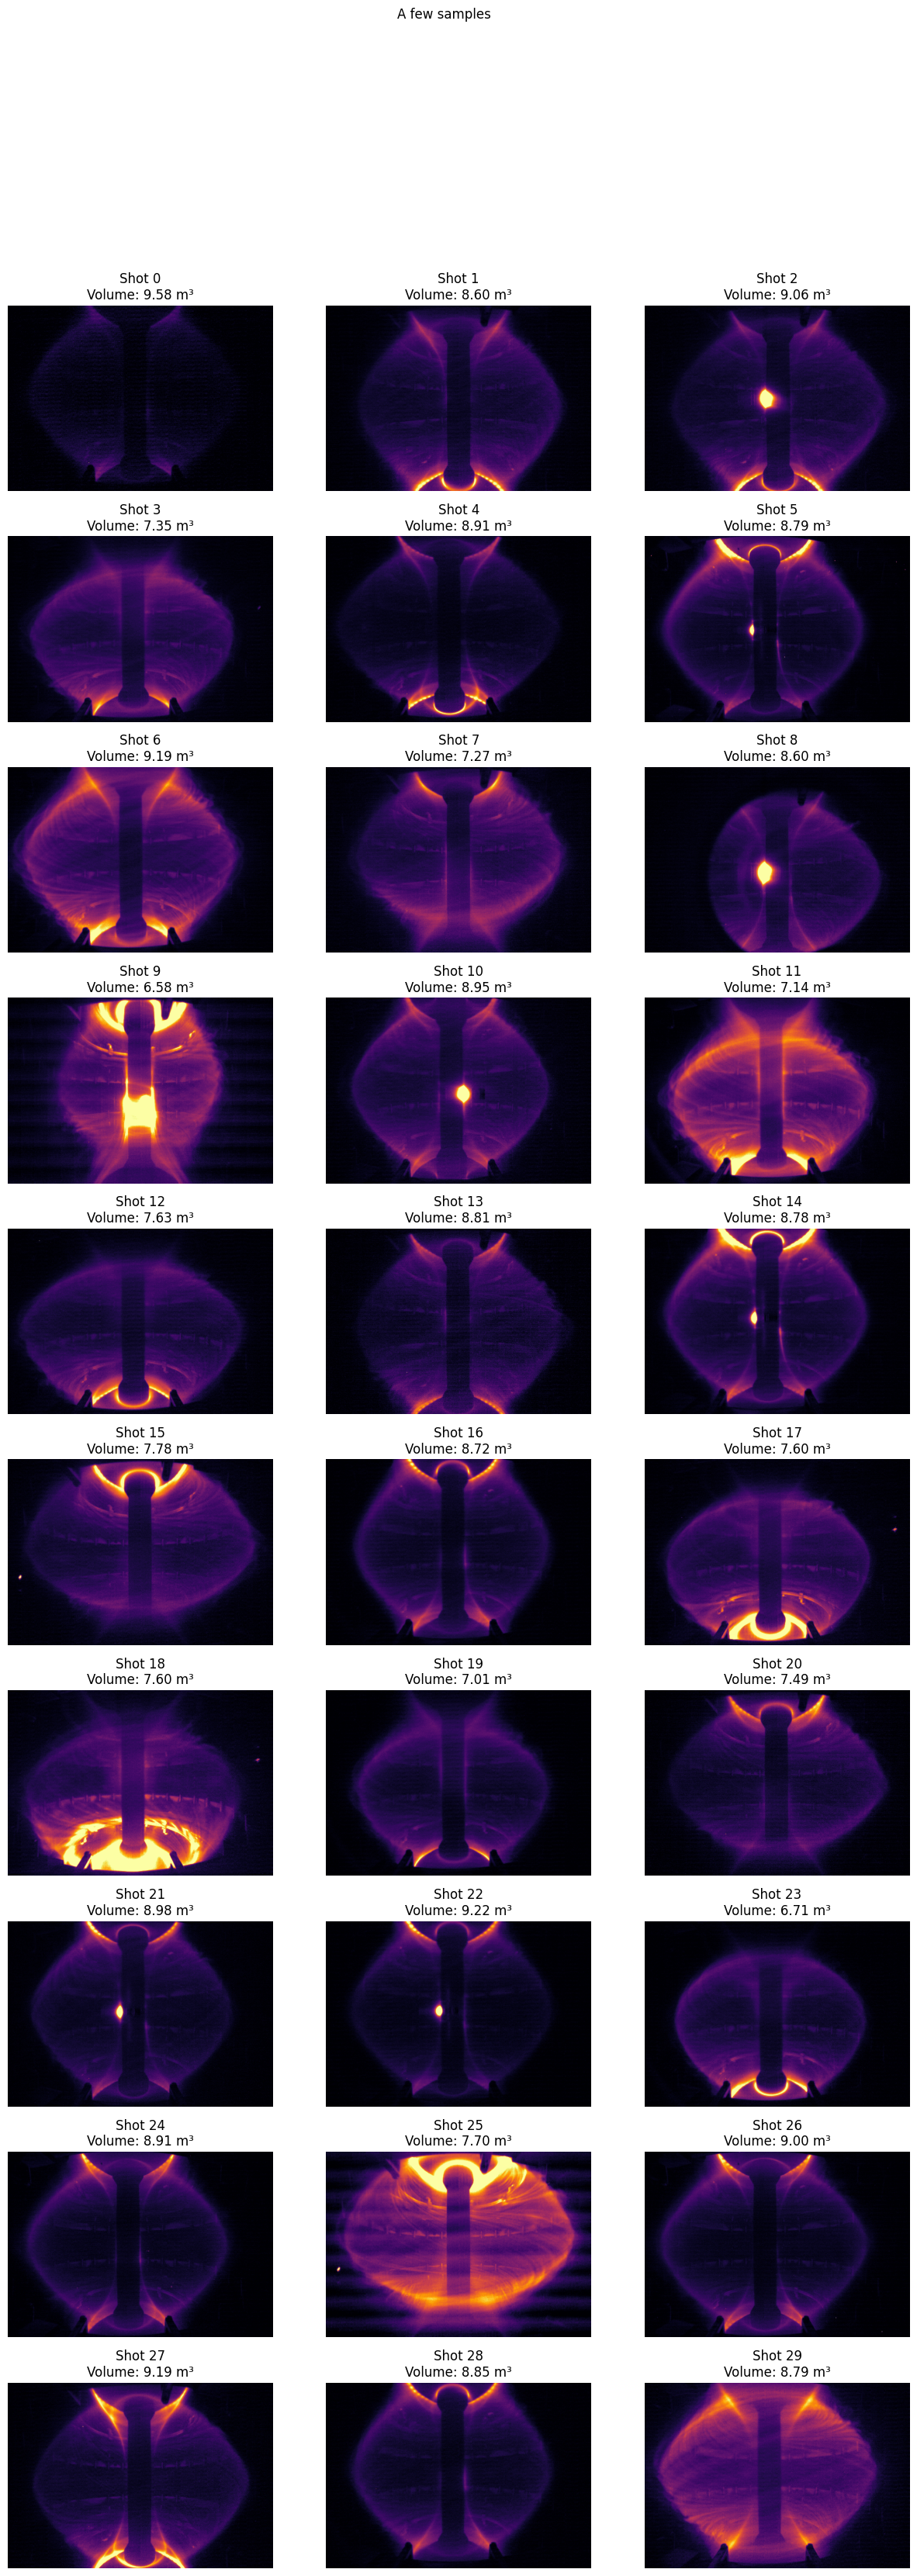

In [3]:
## Louis Brusset 27/05/2025
# Pictural visualization of the first shots

n_samples = 30
number_of_lines = 10
number_of_rows = n_samples//number_of_lines
sample_frames = train.frame.values[:n_samples]  # shape: (n, height, width)

fig, axes = plt.subplots(number_of_lines, number_of_rows, figsize=(15, number_of_lines * 3.8))
for i in range(number_of_lines):
    for j in range(number_of_rows):
        axes[i, j].imshow(sample_frames[i*number_of_rows+j], cmap="inferno")
        axes[i, j].set_title(f"Shot {i*number_of_rows+j}\nVolume: {train.volume[i*number_of_rows+j].values:.2f} m³")
        axes[i, j].axis("off")
plt.suptitle("A few samples")
plt.show()

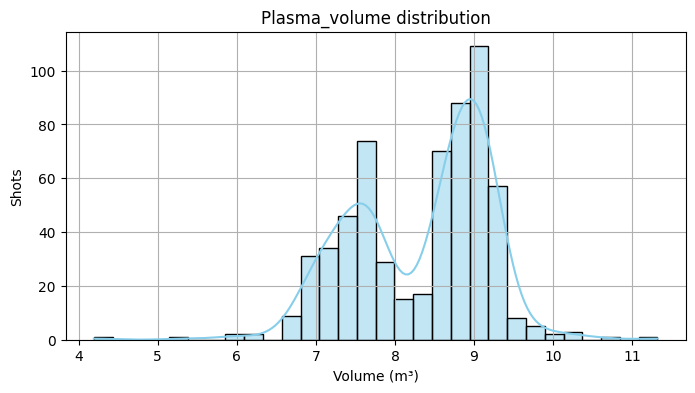

In [4]:
## Louis Brusset 27/05/2025
# Distribution of the plasma volume

plt.figure(figsize=(8, 4))
sns.histplot(train.volume.values, kde=True, bins=30, color="skyblue")
plt.title("Plasma_volume distribution")
plt.xlabel("Volume (m³)")
plt.ylabel("Shots")
plt.grid(True)
plt.show()

3 outliers detected over 605 shots


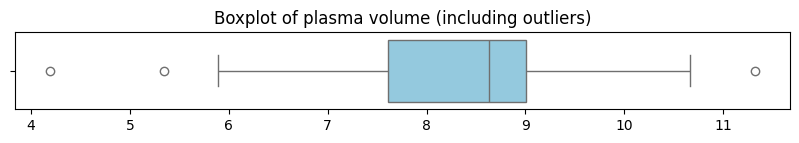

In [5]:
## Louis BRUSSET 28/05/2025
# Outliers detection

q1 = np.percentile(train.volume.values, 25)
q3 = np.percentile(train.volume.values, 75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = (train.volume.values < lower) | (train.volume.values > upper)

print(f"{outliers.sum()} outliers detected over {len(train.volume)} shots")

plt.figure(figsize=(10, 1))
sns.boxplot(x=train.volume.values, color="skyblue")
plt.title("Boxplot of plasma volume (including outliers)")
plt.show()


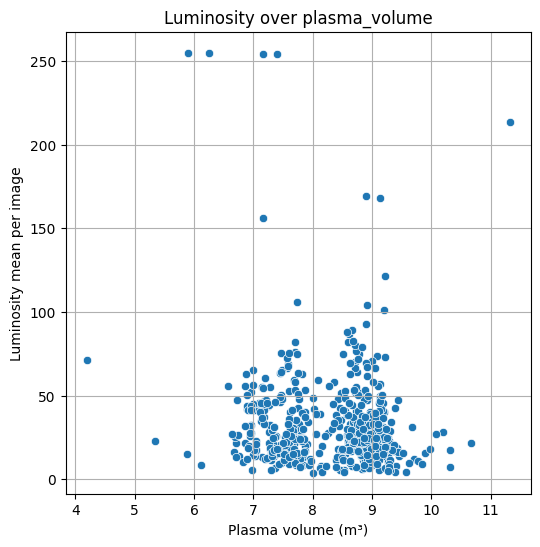

In [6]:
## Louis Brusset 27/05/2025
# Plasma volume over average luminosity

avg_brightness = train.frame.values.mean(axis=(1, 2))

plt.figure(figsize=(6, 6))
sns.scatterplot(y=avg_brightness, x=train.volume.values)
plt.ylabel("Luminosity mean per image")
plt.xlabel("Plasma volume (m³)")
plt.title("Luminosity over plasma_volume")
plt.grid(True)
plt.show()

In [7]:
# Flatten the image dimensions to be analysed in PCA

X_flat = train.frame.values.reshape(train.sizes["shot_id"], -1)

In [39]:
## Louis Brusset 27/05/2025
# PCA

print("X_flat shape: ", X_flat.shape)
n_components = 0.9

pca_09 = sklearn.decomposition.PCA(n_components=n_components)
X_pca_09 = pca_09.fit_transform(X_flat)

X_flat shape:  (605, 286720)


In [107]:
# Explained variance per components
explained_var = pca_09.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, n_components + 1), cumulative_var, marker='s', linestyle='--', label="Variance cumulée")

plt.title("Explained variance by PCA")
plt.xlabel("PC")
plt.ylabel("Part of variance")
plt.xticks(range(1, n_components + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

<Figure size 1000x500 with 0 Axes>

In [8]:
# Only 2 components to be seen on a graph

n_components = 2

pca_2 = sklearn.decomposition.PCA(n_components=n_components)
X_pca_2 = pca_2.fit_transform(X_flat)

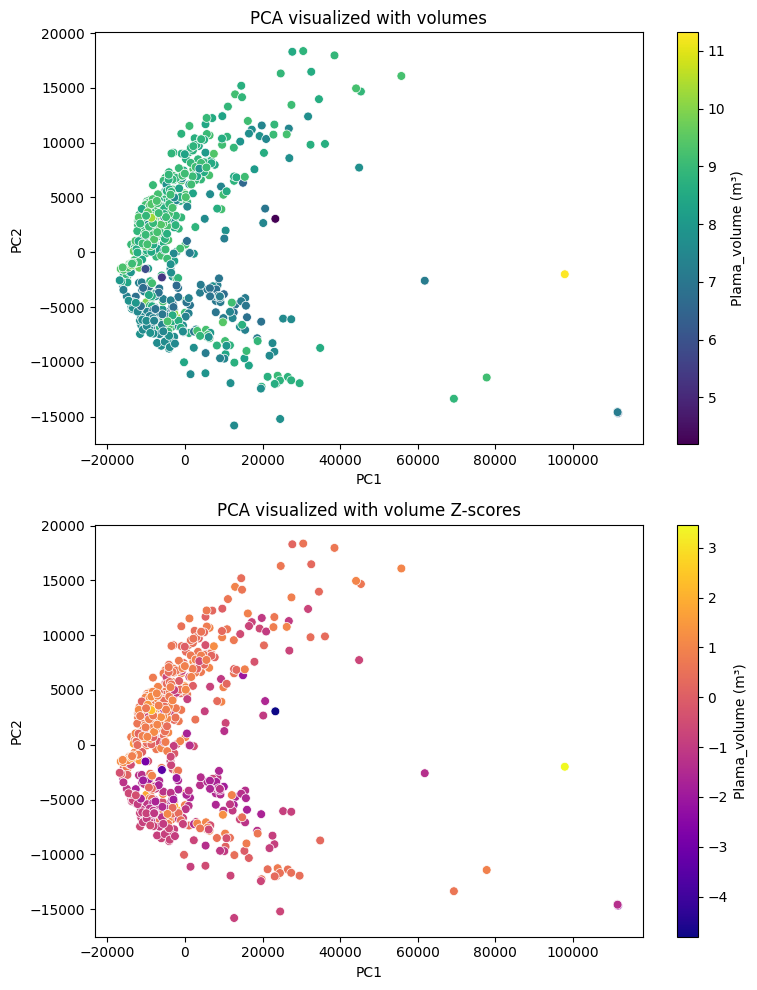

In [9]:
volumes = train.volume.values
volumes_z = (volumes - np.mean(volumes)) / np.std(volumes)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
scatter = sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=volumes, palette="viridis", s=40, ax=ax1, legend=False)
norm1 = plt.Normalize(volumes.min(), volumes.max())
sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
sm1.set_array([])
ax1.set_title("PCA visualized with volumes")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
plt.colorbar(sm1, ax=ax1, label="Plama_volume (m³)")

scatter = sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=volumes_z, palette="plasma", s=40, ax=ax2, legend=False)
norm2 = plt.Normalize(volumes_z.min(), volumes_z.max())
sm2 = plt.cm.ScalarMappable(cmap="plasma", norm=norm2)
sm2.set_array([])
ax2.set_title("PCA visualized with volume Z-scores")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
plt.colorbar(sm2, ax=ax2, label="Plama_volume (m³)")

plt.tight_layout()
plt.show()

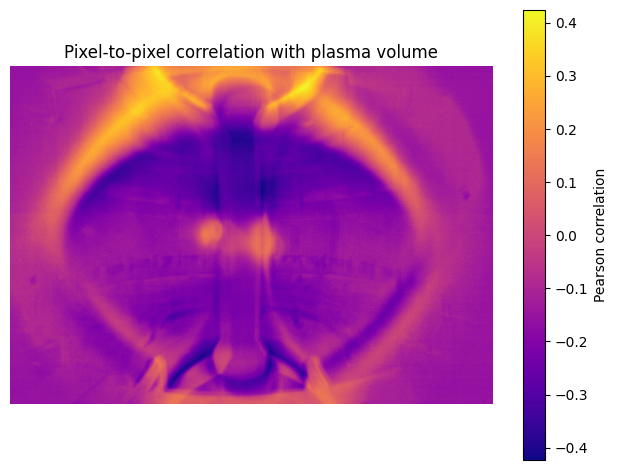

In [10]:
## Louis Brusset 27/05/2025
# Which pixel of the image is the most important in mean to explain the volume variance
# We are using the Pearson's correlation formula

correlations = [pearsonr(X_flat[:, i], train.volume.values)[0] for i in range(X_flat.shape[1])]
correlation_image = np.array(correlations).reshape(train.frame.shape[1:])  # (H, W)

plt.imshow(correlation_image, cmap="plasma")
plt.title("Pixel-to-pixel correlation with plasma volume")
plt.colorbar(label="Pearson correlation")
plt.axis("off")
plt.tight_layout()
plt.show()

## Outliers handling

* Statistical filtering
* Interquartile range (IQR) method
* DBSCAN clustering
* Winsorization
* IsolationForest model

Note: We will use IsolationForest before DBSCAN, because IsolationForest is good in high dimensionality contrary to DBSCAN ; and we will place a dimension reduction in between.

After each modification, we will be using the PCA with two principal components to see the improvments.


__Louis Brusset__ _27/05/2025_

In [23]:
## Louis Brusset 28/05/2025
# Split the set between train and validation set

X = train.frame.values  # shape: (n_shots, height, width)
y = train.volume

X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=7)

# Créer les versions aplaties
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

In [24]:
## Louis Brusset 28/05/2025
# Global function to find and plot the 2 principals components and plot the target distibution.

def plot_pca2_and_distribution(new_X_flat, new_y):

    n_components = 2
    pca_2 = sklearn.decomposition.PCA(n_components=n_components)
    X_pca_2 = pca_2.fit_transform(new_X_flat)

    volumes = new_y

    fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
    scatter = sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=volumes, palette="viridis", s=40, ax=ax1, legend=False)
    norm1 = plt.Normalize(volumes.min(), volumes.max())
    sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm1)
    sm1.set_array([])
    plt.colorbar(sm1, ax=ax1, label="Plama_volume (m³)")
    ax1.set_title("PCA visualized unnormed with volumes")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

    sns.histplot(volumes, kde=True, bins=30, color="skyblue")
    ax2.set_title("Plasma_volume distribution")
    ax2.set_xlabel("Volume (m³)")
    ax2.set_ylabel("Shots")

    ax1.grid(True)
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def show_outlier_images(X_original, y_original, outlier_mask, image_shape=(448, 640), max_images=20):
    """
    Displays images identified as outliers with their volume (target).

    Args:
        X_original (np.ndarray): Original flattened data, shape (n_samples, n_features)
        y_original (np.ndarray or xarray.DataArray): Data-related targets
        outlier_mask (np.ndarray): Boolean mask where True = outlier (of size n_samples)
        image_shape (tuple): Original image shape (height, width)
        max_images (int): Maximum number of images to display
    """
    # Take outlier indices
    outlier_indices = np.where(outlier_mask)[0]
    num_to_show = min(len(outlier_indices), max_images)

    if num_to_show == 0:
        print("Aucun outlier à afficher.")
        return

    # Setup
    plt.figure(figsize=(num_to_show*4, 3))
    for i, idx in enumerate(outlier_indices[:num_to_show]):
        image = X_original[idx].reshape(image_shape)
        volume = y_original[idx].item() if isinstance(y_original, xr.DataArray) else y_original[idx]

        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(image, cmap='magma')
        plt.title(f"Volume: {volume:.2f}")
        plt.axis('off')

    plt.suptitle(f"{num_to_show} detected outliers")
    plt.tight_layout()
    plt.show()

In [26]:
## Louis Brusset 28/05/2025
# Statistical filtering
# On the targets

def remove_outliers_3std(X, y):
    """
    Deletes samples whose target deviates from the mean by more than 3 standard deviations.
    
    Args:
        X (np.ndarray or xarray.DataArray): Input data, shape (n_samples, ...)
        y (np.ndarray or xarray.DataArray): Target values, shape (n_samples,)
    
    Returns:
        X_filtered, y_filtered: Filtered data
    """
    y_values = y.values if isinstance(y, xr.DataArray) else y

    mean = np.mean(y_values)
    std = np.std(y_values)

    mask = np.abs(y_values - mean) <= 3 * std

    nb_outliers = mask.shape[0] - np.sum(mask)

    X_filtered = X.isel(shot_id=mask) if isinstance(X, xr.DataArray) else X[mask]
    y_filtered = y.isel(shot_id=mask) if isinstance(y, xr.DataArray) else y[mask]

    # Plot outlier images with their volumes
    show_outlier_images(X_train_flat, y_train, ~mask, image_shape=(448, 640), max_images=15)

    return X_filtered, y_filtered, nb_outliers

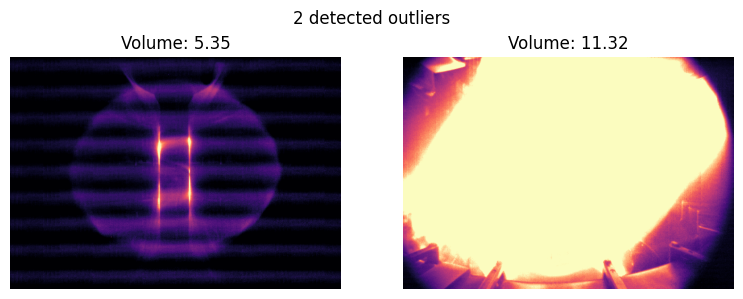

Number of outliers found:  2


In [27]:
new_X_train_flat1, new_y_train1, nb_outliers1 = remove_outliers_3std(X_train_flat, y_train)

print("Number of outliers found: ", nb_outliers1)

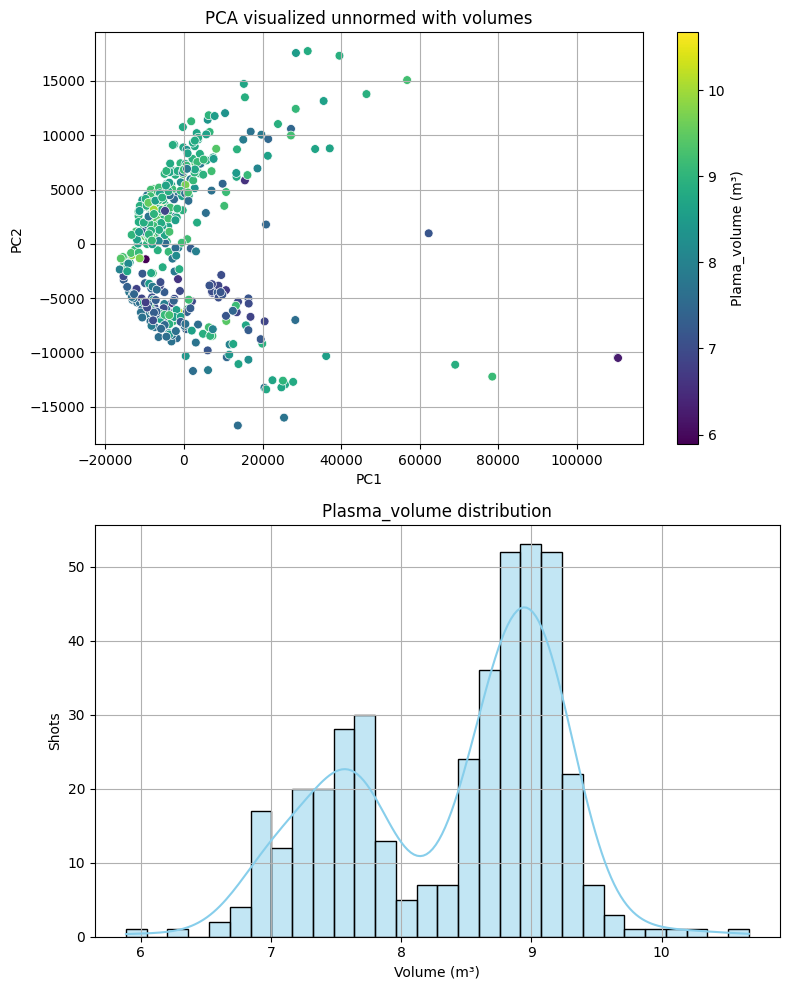

In [16]:
plot_pca2_and_distribution(new_X_train_flat1, new_y_train1)

In [28]:
## Louis Brusset 28/05/2025
# Interquartile range method - IQR
# On the targets

def remove_outliers_iqr(X, y):
    """
    Deletes samples whose target is outside the IQR interval (1.5 * IQR).
    
    Args:
        X (np.ndarray or xarray.DataArray): Input data, shape (n_samples, ...)
        y (np.ndarray or xarray.DataArray): Target values, shape (n_samples,)
    
    Returns:
        X_filtered, y_filtered, nb_outliers: Filtered data and number of outliers detected
    """
    y_values = y.values if isinstance(y, xr.DataArray) else y

    Q1 = np.percentile(y_values, 25)
    Q3 = np.percentile(y_values, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (y_values >= lower_bound) & (y_values <= upper_bound)
    nb_outliers = mask.shape[0] - np.sum(mask)

    X_filtered = X.isel(shot_id=mask) if isinstance(X, xr.DataArray) else X[mask]
    y_filtered = y.isel(shot_id=mask) if isinstance(y, xr.DataArray) else y[mask]

    # Plot outlier images with their volumes
    show_outlier_images(X_train_flat, y_train, ~mask, image_shape=(448, 640), max_images=15)

    return X_filtered, y_filtered, nb_outliers


In [29]:
new_X_train_flat2, new_y_train2, nb_outliers2 = remove_outliers_iqr(new_X_train_flat1, new_y_train1)

print("Number of outliers found: ", nb_outliers2)

Aucun outlier à afficher.
Number of outliers found:  0


The two outliers found if we would have used X_train and y_train without the 3STD methods are the same that those we found with the 3STD method.

In [30]:
# plot_pca2_and_distribution(new_X_train_flat2, new_y_train2)

In [45]:
## Louis Brusset 28/05/2025
# IsolationForest method

def remove_outliers_isolation_forest(X, y, contamination=0.01, random_state=42):
    """
    Removes outliers using Isolation Forest.

    Args:
        X (np.ndarray or xarray.DataArray): Input data, shape (n_samples, n_features)
        y (np.ndarray or xarray.DataArray): Target values, shape (n_samples,)
        contamination (float): Expected proportion of outliers in the data.
        random_state (int): Seed for reproducibility.

    Returns:
        X_filtered, y_filtered, nb_outliers: Filtered data and number of outliers detected.
    """
    X_values = X.values if isinstance(X, xr.DataArray) else X
    y_values = y.values if isinstance(y, xr.DataArray) else y

    # Scaling (important for tree-based models on heterogeneous data)
    X_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_values)
    # Reduction of dimension (important for  the image treatement with a tree)
    reducer = sklearn.decomposition.PCA(n_components=100)
    X_reduced = reducer.fit_transform(X_scaled)
    # Fit Isolation Forest model
    iso = sklearn.ensemble.IsolationForest(contamination=contamination, random_state=random_state)
    labels = iso.fit_predict(X_reduced)  # -1 = outlier, 1 = inlier

    # Show results
    scores = -iso.decision_function(X_reduced)
    sorted_scores = np.sort(scores)
    plt.figure(figsize=(8, 4))
    plt.plot(sorted_scores)
    plt.title("Distribution of outlier scores (sorted)")
    plt.xlabel("Samples (sorted)")
    plt.ylabel("Scores")
    threshold = np.percentile(scores, 100 * (1 - contamination))
    plt.axhline(y=threshold, color='red', linestyle='--', label='Potential threshold')
    plt.legend()
    plt.show()

    # Mask for inliers
    mask = labels == 1
    nb_outliers = (~mask).sum()

    # Filter inputs
    X_filtered = X.isel(shot_id=mask) if isinstance(X, xr.DataArray) else X[mask]
    y_filtered = y.isel(shot_id=mask) if isinstance(y, xr.DataArray) else y[mask]

    # Plot outlier images with their volumes
    show_outlier_images(X_train_flat, y_train, ~mask, image_shape=(448, 640), max_images=30)

    return X_filtered, y_filtered, nb_outliers


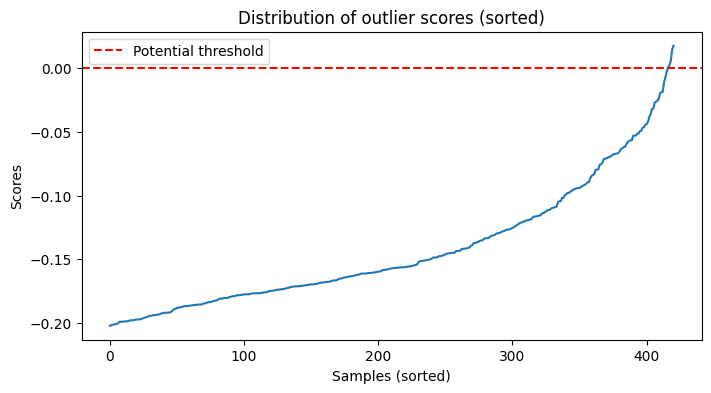

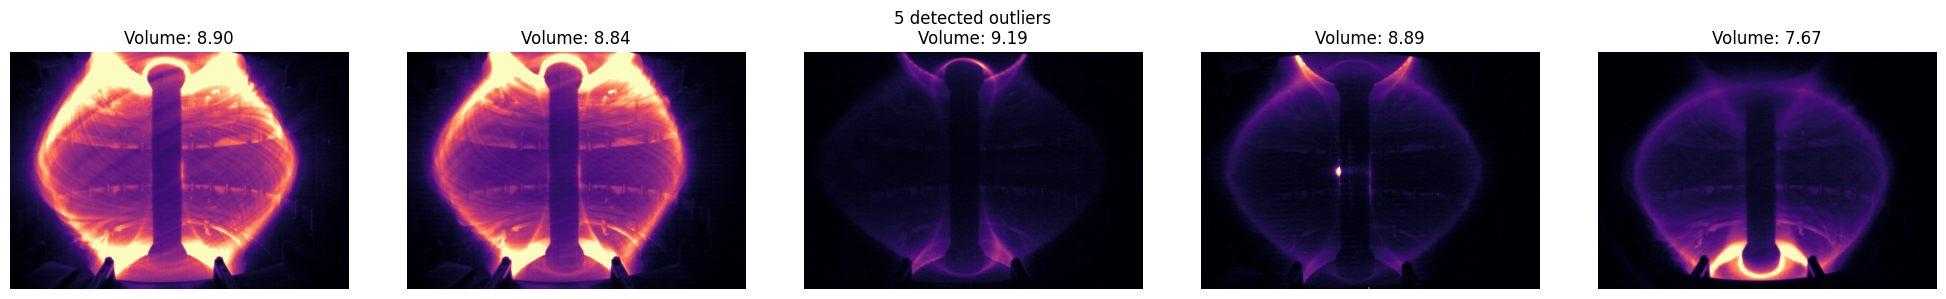

Number of outliers found:  5


In [46]:
new_X_train_flat3, new_y_train3, nb_outliers3 = remove_outliers_isolation_forest(new_X_train_flat2, new_y_train2)

print("Number of outliers found: ", nb_outliers3)

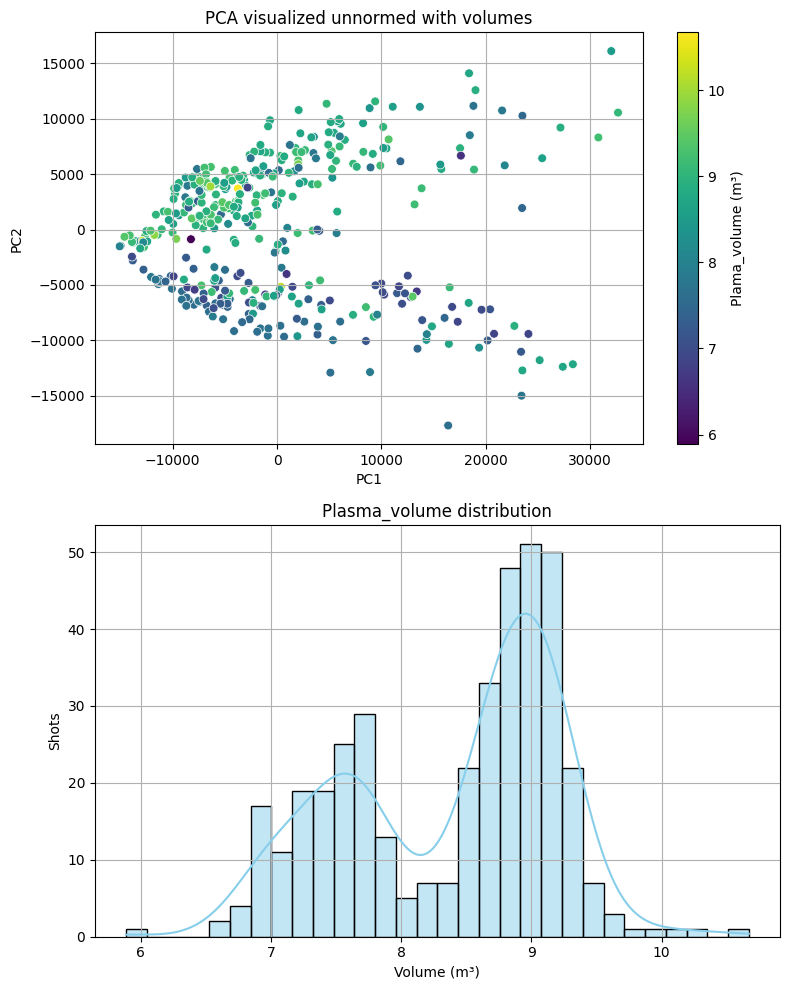

In [140]:
plot_pca2_and_distribution(new_X_train_flat3, new_y_train3)

In [47]:
## Louis Brusset 28/05/2025
# DBSCAN clustering (Density-Based Spatial Clustering of Applications with Noise)
# On the samples

def remove_outliers_dbscan(X, y, eps=150, min_samples=5):
    """
    Removes outliers detected by DBSCAN.

    Args:
        X (np.ndarray or xarray.DataArray): Input data, shape (n_samples, n_features)
        y (np.ndarray or xarray.DataArray): Targets, shape (n_samples,)
        eps (float): Maximum radius for grouping neighboring points.
        min_samples (int): Minimum number of points to form a dense core.

    Returns:
        X_filtered, y_filtered, nb_outliers: Filtered data and number of outliers.
    """
    X_values = X.values if isinstance(X, xr.DataArray) else X
    y_values = y.values if isinstance(y, xr.DataArray) else y

    # We must find the cluster in an embedded space because of the curse of dimensionality.
    # Thus, we use a scaler and we do a PCA.
    X_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_values)
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    dbscan = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_pca)

    # Points with a -1 label are considered outliers.
    mask = labels != -1
    nb_outliers = (~mask).sum()

    X_filtered = X.isel(shot_id=mask) if isinstance(X, xr.DataArray) else X[mask]
    y_filtered = y.isel(shot_id=mask) if isinstance(y, xr.DataArray) else y[mask]


    # Graph visualization of the clustering
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("tab10", n_colors=len(set(labels)) - (1 if -1 in labels else 0))

    for label in set(labels):
        color = 'red' if label == -1 else palette[label % len(palette)]
        label_mask = labels == label
        plt.scatter(X_pca[label_mask, 0], X_pca[label_mask, 1], 
                    label=f'Outlier' if label == -1 else f'Cluster {label}',
                    color=color, s=40, alpha=0.7, edgecolor='k')

    plt.title("DBSCAN clustering (PCA projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot outlier images with their volumes
    show_outlier_images(X_train_flat, y_train, ~mask, image_shape=(448, 640), max_images=15)

    return X_filtered, y_filtered, nb_outliers


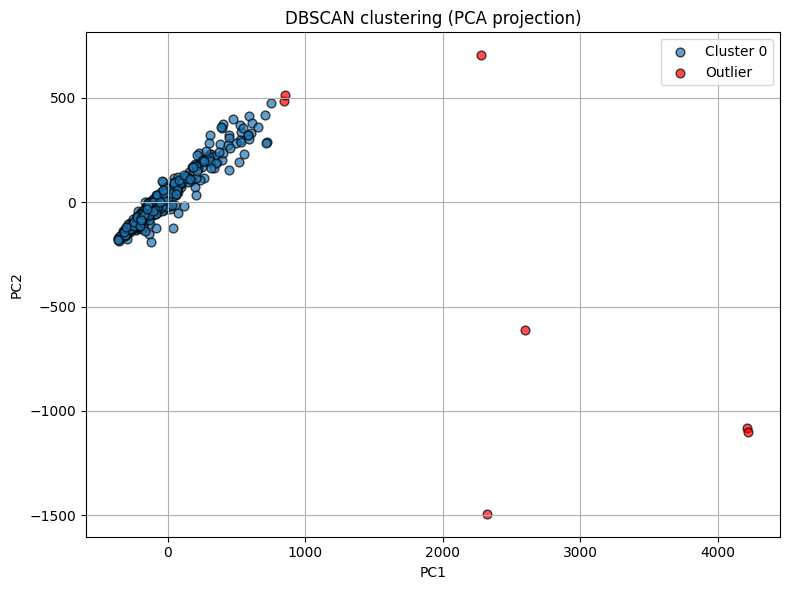

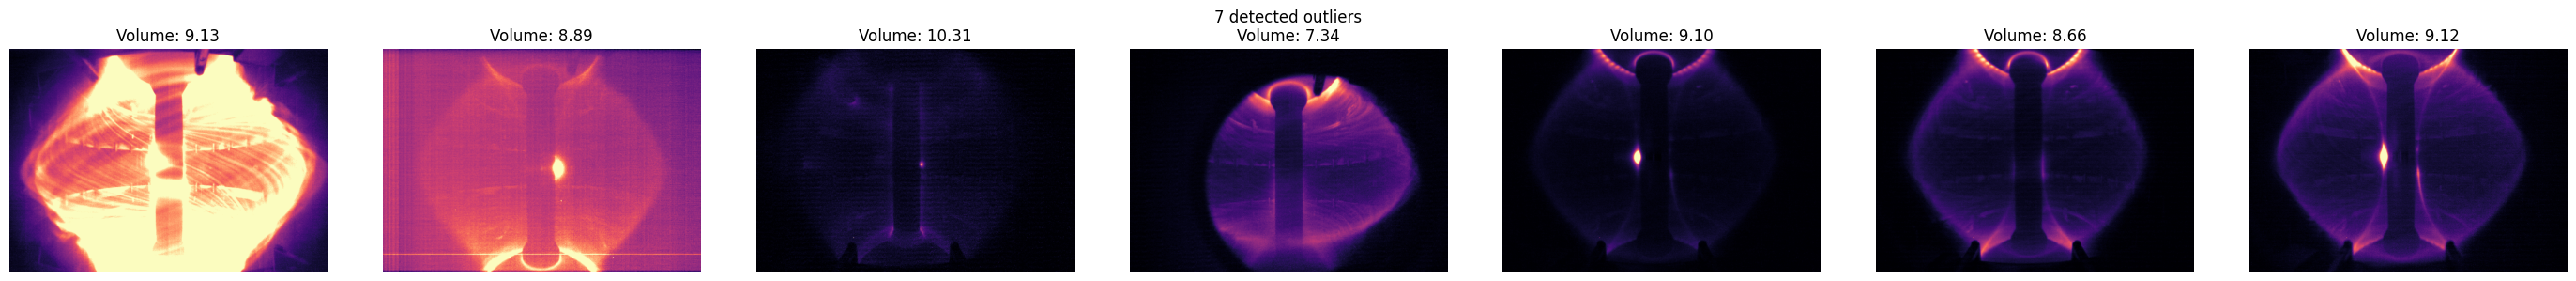

Number of outliers found:  7


In [48]:
new_X_train_flat4, new_y_train4, nb_outliers4 = remove_outliers_dbscan(new_X_train_flat3, new_y_train3)

print("Number of outliers found: ", nb_outliers4)

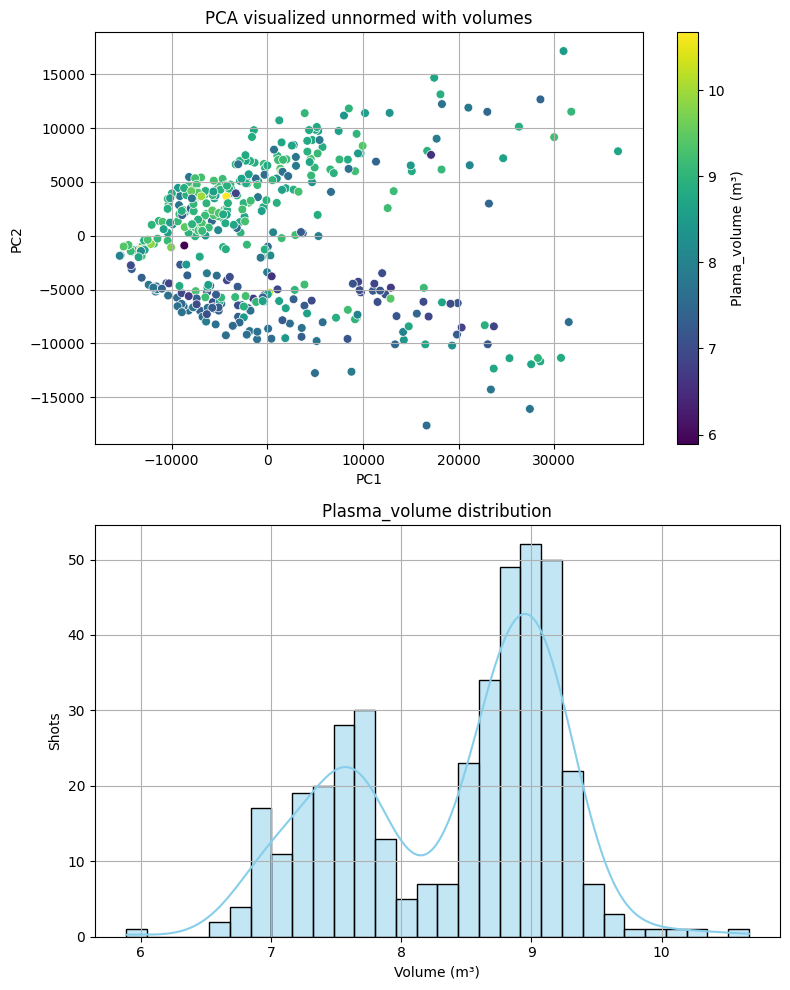

In [49]:
plot_pca2_and_distribution(new_X_train_flat4, new_y_train4)

In [24]:
## Louis Brusset 28/05/2025
# Winsorization


def remove_outliers_winsorization(X, y, lower_percentile=5, upper_percentile=95):
    """
    Applies Winsorization by limiting extreme target values to fixed percentiles,
    both on y (target) and on X (samples) feature-wise.

    Args:
        X (np.ndarray or xarray.DataArray): Input data, shape (n_samples, ...)
        y (np.ndarray or xarray.DataArray): Target values, shape (n_samples,)
        lower_percentile (float): Lower bound percentile (e.g., 5 for 5%)
        upper_percentile (float): Upper bound percentile (e.g., 95 for 95%)

    Returns:
        X_winsorized, y_winsorized, nb_winsorized_y, nb_winsorized_X: Winsorized data and counts of modified values.
    """
    y_values = y.values if isinstance(y, xr.DataArray) else y
    X_values = X.values if isinstance(X, xr.DataArray) else X

    # Winsorize y (target)
    lower_bound_y = np.percentile(y_values, lower_percentile)
    upper_bound_y = np.percentile(y_values, upper_percentile)
    y_winsorized_values = np.clip(y_values, lower_bound_y, upper_bound_y)           # Clipping
    nb_winsorized_y = np.sum((y_values < lower_bound_y) | (y_values > upper_bound_y))

    # Winsorize X (features) feature-wise
    X_winsorized_values = X_values.copy()
    nb_winsorized_X = 0
    for i in range(X_values.shape[1]):
        lower_bound_X = np.percentile(X_values[:, i], lower_percentile)
        upper_bound_X = np.percentile(X_values[:, i], upper_percentile)
        clipped_column = np.clip(X_values[:, i], lower_bound_X, upper_bound_X)
        nb_winsorized_X += np.sum((X_values[:, i] < lower_bound_X) | (X_values[:, i] > upper_bound_X))
        X_winsorized_values[:, i] = clipped_column

    # Rebuild outputs respecting input type
    X_winsorized = X_winsorized_values if not isinstance(X, xr.DataArray) else xr.DataArray(X_winsorized_values, dims=X.dims, coords=X.coords)
    y_winsorized = y_winsorized_values if not isinstance(y, xr.DataArray) else xr.DataArray(y_winsorized_values, dims=y.dims, coords=y.coords)
    
    # Visualization for y only (optional)
    plt.figure(figsize=(8, 4))
    sns.histplot(y_values, color="skyblue", bins=30, kde=True, label="Original", stat="density")
    sns.histplot(y_winsorized_values, color="orange", bins=30, kde=True, label="Winsorized", stat="density", alpha=0.6)
    plt.axvline(lower_bound_y, color='red', linestyle='--', label=f"{lower_percentile}th percentile")
    plt.axvline(upper_bound_y, color='green', linestyle='--', label=f"{upper_percentile}th percentile")
    plt.title("Winsorization of Target Variable")
    plt.xlabel("Target values")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return X_winsorized, y_winsorized, nb_winsorized_y, nb_winsorized_X

In [17]:
X_without_outliers = new_X_train_flat4       #.reshape(train.frame.shape)
y_without_outliers = new_y_train4

For our topic, we are not going to use Winsorization, because to make it meaning full we must move the data in an embedded space (avec a dimension reduction with PCA), so that it is not possible to understand the new meaning of the image we would just have created.

So we are staying with statistical method and clustering: we loose 9 samples but it is affordable for the model.

### Build again a simple model

To see if the outlier handling was usefull.

In [18]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.decomposition.KernelPCA(n_components=25),
    sklearn.linear_model.LinearRegression(),
)

In [29]:
print("X_without_outliers shape", X_without_outliers.shape)
print("y_without_outliers shape", y_without_outliers.shape)
print("X_valid shape", X_valid.shape)
print("X_valid_flat shape", X_valid_flat.shape)

X_without_outliers shape (389, 286720)
y_without_outliers shape (389,)
X_valid shape (182, 448, 640)
X_valid_flat shape (182, 286720)


In [31]:
# Train the model on the training data
pipeline.fit(X_without_outliers, y_without_outliers)

# Make predictions on the validation data
y_predict_without_outliers = pipeline.predict(X_valid_flat)

# Calculate R² score (coefficient of determination)
# Higher values indicate better model fit (1.0 is perfect, 0.0 is equivalent to predicting the mean)
R2_without_outliers = sklearn.metrics.r2_score(y_valid, y_predict_without_outliers)
print(f"Model R² without outliers: {R2_without_outliers:.3f} (higher is better)")


Model R² without outliers: 0.324 (higher is better)


In [32]:
# Make predictions for the test dataset
volume = pipeline.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))

# Create and save submission file
solution = pd.DataFrame(
    {"plasma_volume": volume}, index=pd.Index(test.shot_id, name="shot_id")
)
solution.to_csv(path / "linear_regression_without_outliers.csv")

In [34]:
# Define parameter grid
param_grid = {
    'kernelpca__n_components': [25, 50, 100],
    'kernelpca__kernel': ['linear', 'rbf', 'poly'],
    'linearregression__fit_intercept': [True, False]
}

# Create grid search
grid_search = sklearn.model_selection.GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

# Train the model
grid_search.fit(X_without_outliers, y_without_outliers)

# Best parameters and score
print(f"Best parameters without outliers: {grid_search.best_params_}")
print(f"Best CV score without outliers: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model_without_ourliers = grid_search.best_estimator_
y_predict_best_without_ourliers = best_model_without_ourliers.predict(X_valid_flat)
R2_best_without_ourliers = sklearn.metrics.r2_score(y_valid, y_predict_best_without_ourliers)
print(f"Best model R2 without outliers: {R2_best_without_ourliers:.3f}")

# Generate final predictions
best_volume_without_ourliers = best_model_without_ourliers.predict(test.frame.values.reshape(test.sizes["shot_id"], -1))
best_solution_without_ourliers = pd.DataFrame(
    {"plasma_volume without outliers": best_volume_without_ourliers}, index=pd.Index(test.shot_id, name="shot_id")
)
best_solution_without_ourliers.to_csv(path / "optimized_regression_without_outliers.csv")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters without outliers: {'kernelpca__kernel': 'linear', 'kernelpca__n_components': 100, 'linearregression__fit_intercept': True}
Best CV score without outliers: 0.739
Best model R2 without outliers: -0.985


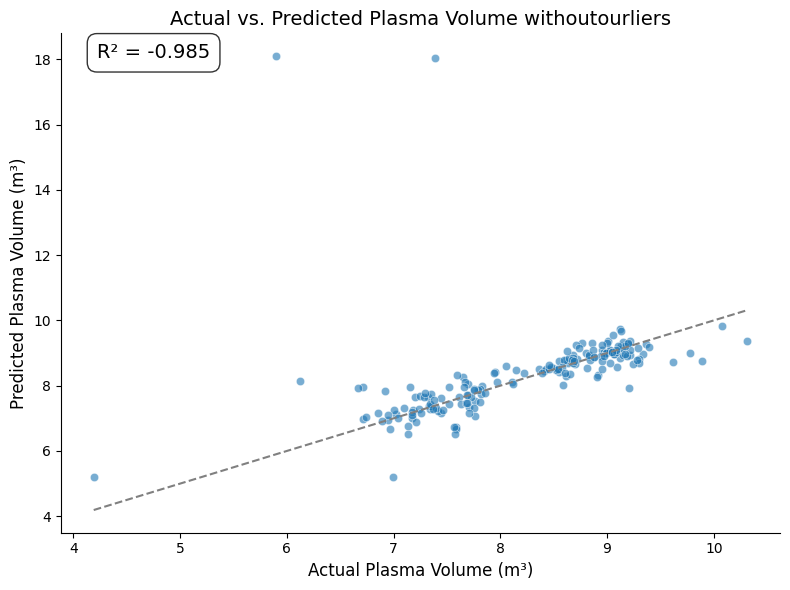

In [36]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))
results_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_predict_best_without_ourliers})

sns.scatterplot(x='Actual', y='Predicted', data=results_df,alpha=0.6,)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], '--', color='gray')
plt.annotate(
    f'R² = {R2_best_without_ourliers:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume withoutourliers', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

There are two predictions that are totally out of bounds. We are going to check if the probleme would not come from the image.

In [48]:
errors = np.abs(y_predict_best_without_ourliers - y_valid)
worst_indices = np.argsort(errors)[-2:]
print("Indices des pires prédictions :", worst_indices)

Indices des pires prédictions : <xarray.DataArray 'volume' (shot_id: 2)> Size: 16B
array([125,  95])
Coordinates:
    volume   (shot_id) float64 16B 9.293 9.131
Dimensions without coordinates: shot_id


In [33]:
def show_worst_predicted_images(X_flat, y_true, y_pred, indices, image_shape=(448, 640)):
    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(indices):
        img = X_flat[idx].reshape(image_shape)
        true_val = y_true[idx]
        pred_val = y_pred[idx]
        
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img, cmap='magma')
        plt.title(f"True: {true_val:.2f}\nPred: {pred_val:.2f}", fontsize=10)
        plt.axis('off')
    
    plt.suptitle("Images with Worst Prediction Errors", fontsize=14)
    plt.tight_layout()
    plt.show()

show_worst_predicted_images(X_valid_flat, y_valid, y_predict_best_without_ourliers, worst_indices)

NameError: name 'y_predict_best_without_ourliers' is not defined

Thoses images are problematic.

So we are going to calculate the R2 without them.

In [50]:
mask = np.ones(len(y_valid), dtype=bool)
mask[worst_indices] = False
R2_cleaned = sklearn.metrics.r2_score(y_valid[mask], y_predict_best_without_ourliers[mask])
print(f"R² après suppression des 2 pires prédictions : {R2_cleaned:.4f}")

R² après suppression des 2 pires prédictions : 0.7585


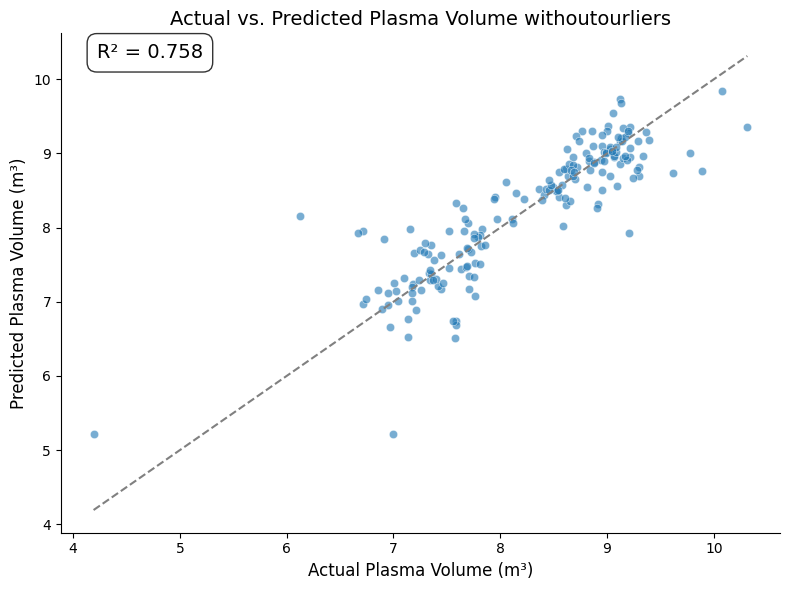

In [51]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))
results_df = pd.DataFrame({'Actual': y_valid[mask], 'Predicted': y_predict_best_without_ourliers[mask]})

sns.scatterplot(x='Actual', y='Predicted', data=results_df,alpha=0.6,)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], '--', color='gray')
plt.annotate(
    f'R² = {R2_cleaned:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume withoutourliers', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

## Feature engineering

* Higher-level features with edge detection or contour analysis.
* Dimensionality reduction more selective than PCA (t-SNE, UMAP).
* Domain-specific features based on tokamak physics.

__Louis BRUSSET__ _30/05/2025_

#### Higher-level features

In [19]:
def extract_edge_features(images, image_shape=(448, 640)):
    """
    Applies Sobel filter to extract edge features.
    
    Args:
        images (np.ndarray): Array of flattened images, shape (n_samples, n_features)
        image_shape (tuple): Original image shape
        
    Returns:
        np.ndarray: Edge-enhanced flattened images
    """
    n_samples = images.shape[0]
    edge_features = []
    for i in range(n_samples):
        img = images[i].reshape(image_shape)
        sobel_x = ndimage.sobel(img, axis=0)
        sobel_y = ndimage.sobel(img, axis=1)
        sobel_mag = np.hypot(sobel_x, sobel_y)
        edge_features.append(sobel_mag.flatten())
    return np.array(edge_features)

In [20]:
def extract_contour_features(images, image_shape=(448, 640)):
    """
    Extracts simple contour features: number of contours and average area.
        
    Args:
        images (np.ndarray): Array of flattened images, shape (n_samples, n_features)
        image_shape (tuple): Original image shape
    
    Returns:
        np.ndarray: Feature vector [n_contours, mean_area] for each image
    """
    n_samples = images.shape[0]
    contour_features = []
    for i in range(n_samples):
        img = images[i].reshape(image_shape).astype(np.uint8)
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        n_contours = len(contours)
        mean_area = np.mean([cv2.contourArea(c) for c in contours]) if contours else 0
        contour_features.append([n_contours, mean_area])
    return np.array(contour_features)

#### Dimentionality reduction

In [21]:
def reduce_umap(X, n_components=20, n_neighbors=15):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=42)
    return reducer.fit_transform(X)

#### Physics based features

In [22]:
# Physics based: ratio between the center and the periferic intensity

def central_intensity_ratio(images, image_shape=(448, 640)):
    """
    Computes the ratio of central intensity over total intensity.
        
    Args:
        images (np.ndarray): Array of flattened images, shape (n_samples, n_features)
        image_shape (tuple): Original image shape

        Returns:
        np.ndarray: Feature vector [tatio] for each image
    """
    center_region = (slice(image_shape[0]//3, 2*image_shape[0]//3),
                     slice(image_shape[1]//3, 2*image_shape[1]//3))
    ratios = []
    for img_flat in images:
        img = img_flat.reshape(image_shape)
        total = np.sum(img)
        center = np.sum(img[center_region])
        ratio = center / total if total > 0 else 0
        ratios.append(ratio)
    return np.array(ratios).reshape(-1, 1)

In [23]:
# Extend the features for the train set and the validation set

# Assemble train and validation set
separation_index = X_without_outliers.shape[0]
print("Separation index between train and validation set: ", separation_index)
X_train_valid_without_outliers = np.concatenate((X_without_outliers, X_valid_flat), axis=0)

Separation index between train and validation set:  389


In [24]:
# Extract new features
edge_features = extract_edge_features(X_train_valid_without_outliers)
print("edge_features shape: ", edge_features.shape)
contour_features = extract_contour_features(X_train_valid_without_outliers)
print("contour_features shape: ", contour_features.shape)
intensity_ratio_features = central_intensity_ratio(X_train_valid_without_outliers)
print("intensity_ratio_features shape: ", intensity_ratio_features.shape)

edge_features shape:  (571, 286720)
contour_features shape:  (571, 2)
intensity_ratio_features shape:  (571, 1)


In [26]:
# Add new_features together
assert edge_features.shape[0]==contour_features.shape[0] and contour_features.shape[0]==intensity_ratio_features.shape[0]

new_features = np.concatenate((edge_features, contour_features, intensity_ratio_features), axis=1)
print("new_features shape: ", new_features.shape)

new_data = np.concatenate((X_train_valid_without_outliers, new_features), axis=1)
print("new_data shape: ", new_data.shape)

new_features shape:  (571, 286723)
new_data shape:  (571, 573443)


In [27]:
# Deassemble train and validation set
X_augmented_train = new_data[:separation_index]
X_augmented_valid = new_data[separation_index:]

### Test this new data with the former pipeline

In [ ]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.decomposition.KernelPCA(n_components=25),
    sklearn.linear_model.LinearRegression(),
)

In [28]:
# Define parameter grid
param_grid = {
    'kernelpca__n_components': [25, 50, 100],
    'kernelpca__kernel': ['linear', 'rbf', 'poly'],
    'linearregression__fit_intercept': [True, False]
}

# Create grid search
grid_search = sklearn.model_selection.GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

# Train the model
grid_search.fit(X_augmented_train, y_without_outliers)

# Best parameters and score
print(f"Best parameters with_feature_aumentation: {grid_search.best_params_}")
print(f"Best CV score with_feature_aumentation: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model_with_feature_aumentation = grid_search.best_estimator_
y_predict_best_with_feature_aumentation = best_model_with_feature_aumentation.predict(X_augmented_valid)
R2_best_with_feature_aumentation = sklearn.metrics.r2_score(y_valid, y_predict_best_with_feature_aumentation)
print(f"Best model R2 with_feature_aumentation: {R2_best_with_feature_aumentation:.3f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/ITER/brussel/Documents/data-science-challenges/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ITER/brussel/Documents/data-science-challenges/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ITER/brussel/Documents/data-science-challenges/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *ar

Best parameters with_feature_aumentation: {'kernelpca__kernel': 'linear', 'kernelpca__n_components': 100, 'linearregression__fit_intercept': True}
Best CV score with_feature_aumentation: 0.689
Best model R2 with_feature_aumentation: 0.624


ValueError: X has 286720 features, but KernelPCA is expecting 573443 features as input.

In [29]:
# Generate final predictions
X_test = test.frame.values.reshape(test.sizes["shot_id"], -1)

# Extract new features
edge_features = extract_edge_features(X_test)
print("edge_features shape: ", edge_features.shape)
contour_features = extract_contour_features(X_test)
print("contour_features shape: ", contour_features.shape)
intensity_ratio_features = central_intensity_ratio(X_test)
print("intensity_ratio_features shape: ", intensity_ratio_features.shape)
assert edge_features.shape[0]==contour_features.shape[0] and contour_features.shape[0]==intensity_ratio_features.shape[0]
new_features = np.concatenate((edge_features, contour_features, intensity_ratio_features), axis=1)
print("new_features shape: ", new_features.shape)

X_test_augmented = np.concatenate((X_test, new_features), axis=1)
print("new_data shape: ", X_test_augmented.shape)


best_volume_with_feature_aumentation = best_model_with_feature_aumentation.predict(X_test_augmented)
best_solution_with_feature_aumentation = pd.DataFrame(
    {"plasma_volume with_feature_aumentation": best_volume_with_feature_aumentation}, index=pd.Index(test.shot_id, name="shot_id")
)
best_solution_with_feature_aumentation.to_csv(path / "optimized_regression_with_feature_aumentation.csv")

edge_features shape:  (259, 286720)
contour_features shape:  (259, 2)
intensity_ratio_features shape:  (259, 1)
new_features shape:  (259, 286723)
new_data shape:  (259, 573443)


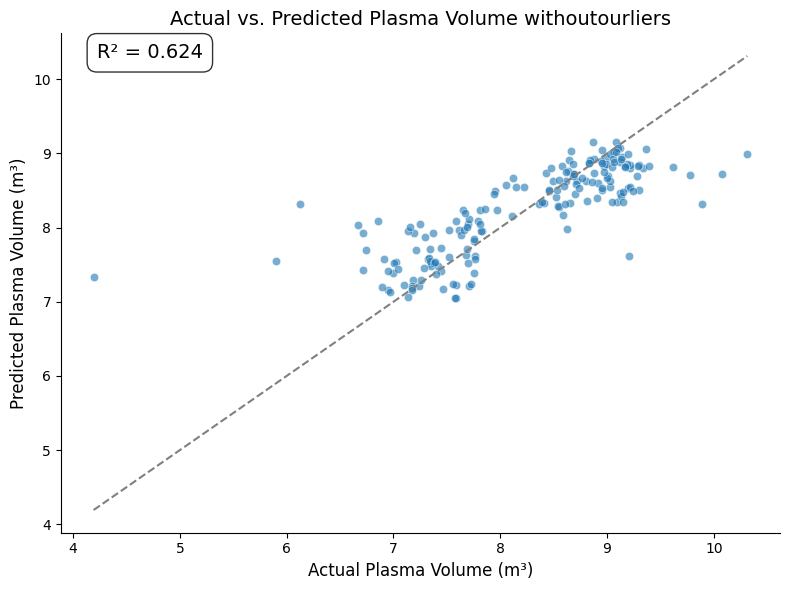

In [30]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))
results_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_predict_best_with_feature_aumentation})

sns.scatterplot(x='Actual', y='Predicted', data=results_df,alpha=0.6,)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], '--', color='gray')
plt.annotate(
    f'R² = {R2_best_with_feature_aumentation:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume withoutourliers', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

Indices des pires prédictions : <xarray.DataArray 'volume' (shot_id: 3)> Size: 24B
array([ 95, 126, 129])
Coordinates:
    volume   (shot_id) float64 24B 9.282 9.293 9.131
Dimensions without coordinates: shot_id


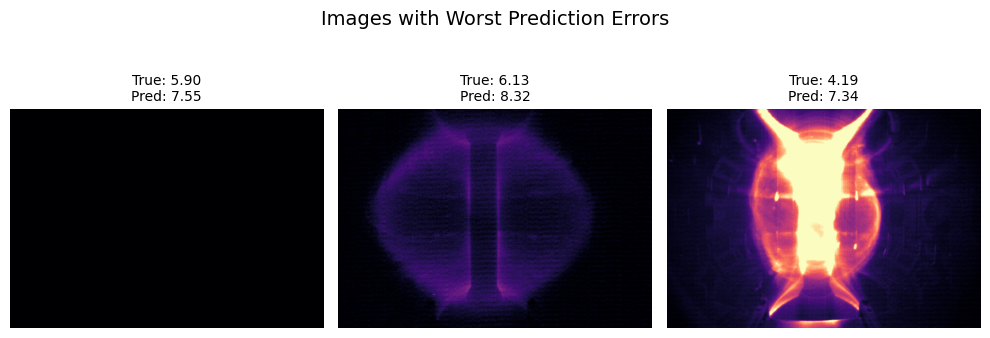

In [37]:
errors = np.abs(y_predict_best_with_feature_aumentation - y_valid)
worst_indices = np.argsort(errors)[-3:]
print("Indices des pires prédictions :", worst_indices)
show_worst_predicted_images(X_valid_flat, y_valid, y_predict_best_with_feature_aumentation, worst_indices)

In [38]:
mask = np.ones(len(y_valid), dtype=bool)
mask[worst_indices] = False
R2_cleaned = sklearn.metrics.r2_score(y_valid[mask], y_predict_best_with_feature_aumentation[mask])
print(f"R² après suppression des 2 pires prédictions : {R2_cleaned:.4f}")

R² après suppression des 2 pires prédictions : 0.6859


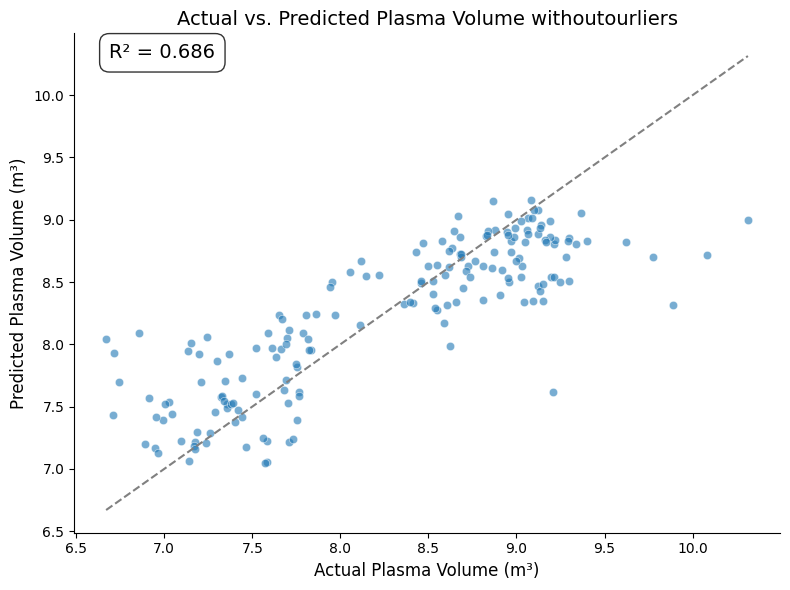

In [39]:
# Visualize model performance using seaborn
plt.figure(figsize=(8, 6))
results_df = pd.DataFrame({'Actual': y_valid[mask], 'Predicted': y_predict_best_with_feature_aumentation[mask]})

sns.scatterplot(x='Actual', y='Predicted', data=results_df,alpha=0.6,)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], '--', color='gray')
plt.annotate(
    f'R² = {R2_cleaned:.3f}', 
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    fontsize=14, 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)
plt.xlabel('Actual Plasma Volume (m³)', fontsize=12)
plt.ylabel('Predicted Plasma Volume (m³)', fontsize=12)
plt.title('Actual vs. Predicted Plasma Volume withoutourliers', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

## Improve the model

* Convolutional Neural Network
* Ensemble method (Random Forests, Gradient Boosting) => better generalization
* Support Vector Regression with non-linear kernels

## 1. CNN - Convolutional NN

In [40]:
# Example CNN model for regression
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(32 * 112 * 160, 128)
        self.fc2 = torch.nn.Linear(128, 1)  # Output: volume (scalar)

    def forward(self, x):
        x = self.pool(torch.nn.functional.F.relu(self.bn1(self.conv1(x))))  # [B, 16, 224, 320]
        x = self.pool(torch.nn.functional.F.relu(self.bn2(self.conv2(x))))  # [B, 32, 112, 160]
        x = x.view(x.size(0), -1)  # flatten
        x = torch.nn.functional.F.relu(self.fc1(x))
        return self.fc2(x)

# Wrap with skorch
net = NeuralNetRegressor(
    CNNRegressor,
    max_epochs=20,
    lr=0.001,
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

def normalize_images(X):
    # X shape: (n_samples, 1, H, W)
    # Normaliser par image (pixel-wise)
    X_norm = (X - X.mean(axis=(2,3), keepdims=True)) / (X.std(axis=(2,3), keepdims=True) + 1e-8)
    return X_norm

# Optional: preprocess if input isn't already normalized
# Ensure X is of shape (n_samples, 1, 448, 640)
pipeline = make_pipeline(
    sklearn.preprocessing.FunctionTransformer(normalize_images, validate=False),
    net
)

NameError: name 'torch' is not defined

In [ ]:
X_train_reshaped_cnn = X_without_outliers.reshape(-1, 1, 448, 640).astype(np.float32)
print("X_train_reshaped_cnn: ", X_train_reshaped_cnn)

In [ ]:
pipeline.fit(X_train_reshaped_cnn, y_without_outliers.astype(np.float32))